In [1]:
%matplotlib inline
import sys
import matplotlib
import matplotlib.pyplot as plt
import glob, os
import numpy as np
from numpy.polynomial import polynomial as P
import re, csv
import pandas as pd
from math import sqrt
import seaborn as sns
from numpy.polynomial import polynomial as P
from scipy import stats
from scipy.stats import linregress
sns.set_style("whitegrid")
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [22]:
# Load Voimooo python wrapper
sys.path.insert(0, os.path.abspath('../../pyvoimooo/'))
import pyvoimooo as vmo
vmo.__version__

INFO: Wav write/read: Using libsndfile in Voimooo


'0.17.6'

In [23]:
sys.path.insert(0, os.path.abspath('../../cleese'))
import cleese 

# Analyse de données revcor SMILE
Données patients 2020 recueillies par Stéphanie Miny (CNAM)\
Données contrôles 2017 recueillies par Emmanuel Ponsot, Pablo Arias & JJ Aucouturier (CNRS)\

### Organisation des données

In [61]:
datasets = [{'type':'patients','exp':'miny'},
            {'type':'controls','exp':'ponsot'},
           {'type':'tours','exp':'gomot'}]

data = pd.DataFrame()

for dataset in datasets: 
    result_dir = 'data/'+dataset['type']+'/'
    result_files = glob.glob(result_dir+"results_subj*.csv")
    results = pd.DataFrame()
    for result_file in result_files: 
        print(result_file)
        participant_results = pd.read_csv(result_file, sep = ',', decimal='.', header='infer')
        results = results.append(participant_results, ignore_index=True)
    results['type'] = dataset['type']
    results['experimentateur'] = dataset['exp']
    data = data.append(results, ignore_index=True)

data/patients\results_subj1_200717_15.48.csv
data/patients\results_subj1_200723_17.13.csv
data/patients\results_subj1_200730_16.59.csv
data/patients\results_subj2_200722_11.04.csv
data/patients\results_subj3_200722_14.46.csv
data/patients\results_subj3_200722_15.58.csv
data/patients\results_subj3_200729_10.54.csv
data/patients\results_subj4_200724_15.45.csv
data/patients\results_subj4_200727_14.34.csv
data/patients\results_subj4_200803_11.22.csv
data/patients\results_subj5_200727_11.30.csv
data/patients\results_subj6_200727_16.39.csv
data/patients\results_subj7_200729_16.42.csv
data/controls\results_subj10_19-May-2017.csv
data/controls\results_subj1_19-May-2017.csv
data/controls\results_subj2_19-May-2017.csv
data/controls\results_subj3_19-May-2017.csv
data/controls\results_subj4_19-May-2017.csv
data/controls\results_subj5_19-May-2017.csv
data/controls\results_subj6_19-May-2017.csv
data/controls\results_subj7_19-May-2017.csv
data/controls\results_subj8_19-May-2017.csv


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


data/controls\results_subj9_19-May-2017.csv
data/tours\results_subj1_210111_14.41.csv
data/tours\results_subj2_210324_10.33.csv


In [65]:
# fix subject name tours
data.loc[(data.type=='tours')&(data.sex=='m'),['subj','session']]=[2,1]

In [66]:
# nombre de participants
data[data.type=='tours'].groupby(['experimentateur','sex']).agg({'subj':'nunique',
                                                                    'age':'mean'})

subj   age
experimentateur sex            
gomot           f       1  47.0
                m       1   7.0

In [69]:
# nb de sessions par participants
data[data.type=='tours'].groupby(['subj']).agg({'session':'nunique'})

,session
subj,
1,1
2,1


### Calcul des kernels d'ordre 1 (d'après Ponsot et al. PNAS 2018)

On calcule un kernel par participant et par session

In [89]:
data[(data.type=='tours')&
     (data.subj==2)&(data.trial==1)&(data.stim_order==1)][['filter_freq','filter_gain','response']]

,filter_freq,filter_gain,response
507675,100,-2.624990,0
507676,191,5.282356,0
507677,293,-0.773472,0
507678,406,8.207044,0
507679,533,1.933733,0
507680,673,-3.493214,0
507681,830,4.040656,0
507682,1004,-7.024829,0
507683,1199,-2.267877,0
507684,1416,-4.821471,0


In [75]:
data[(data.type=='tours')&(data.subj==2)].groupby('trial').response.count()

trial
0      50
1      50
2      50
3      50
4      50
       ..
98     50
99     50
100    50
101    50
102    50
Name: response, Length: 103, dtype: int64

In [70]:
# first-order kernel computed for each subject as the
# mean(filter gains of voices classified as smiling) - (mean filter gains of voices classified as non-smiling)
filter_mean_gain = data.groupby(['type','subj','session','filter_freq','response'])['filter_gain'].mean().reset_index()
positives = filter_mean_gain.loc[filter_mean_gain['response'] == 1].reset_index()
negatives = filter_mean_gain.loc[filter_mean_gain['response'] == 0].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','type','session','filter_freq'])
kernels['kernel_gain'] = kernels['filter_gain_x'] - kernels['filter_gain_y']

# Kernels are then normalized for each participant by dividing them 
# by the square root of the sum of their squared values.
kernels['square_gain'] = kernels['kernel_gain']**2
for_norm = kernels.groupby(['subj','session','type'])['square_gain'].mean().reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','type','session'])
kernels['norm_gain'] = kernels['kernel_gain']/np.sqrt(kernels['square_gain_y'])

kernels.drop(columns=['index_x','response_x','filter_gain_x',
                      'index_y','response_y','filter_gain_y',
                      'square_gain_x', 'square_gain_y'], inplace=True)

In [92]:
kernels[(kernels.type=='tours')&(kernels.subj==2)]

,type,subj,session,filter_freq,kernel_gain,norm_gain
600,tours,2,1.0,100,-0.945717,-1.413433
601,tours,2,1.0,191,0.593628,0.887214
602,tours,2,1.0,293,-0.750215,-1.121243
603,tours,2,1.0,406,-0.880436,-1.315866
604,tours,2,1.0,533,0.034413,0.051433
605,tours,2,1.0,673,0.658775,0.984581
606,tours,2,1.0,830,-1.172442,-1.752287
607,tours,2,1.0,1004,-0.784613,-1.172653
608,tours,2,1.0,1199,-0.718108,-1.073257
609,tours,2,1.0,1416,1.302715,1.946989


In [48]:
print(list(kernels))
kernels.to_csv('kernels.csv')

['type', 'subj', 'session', 'filter_freq', 'kernel_gain', 'norm_gain']


In [49]:
kernels[kernels.type=='tours']

,type,subj,session,filter_freq,kernel_gain,norm_gain
575,tours,1,1.0,100,-0.545701,-0.655803
576,tours,1,1.0,191,-1.343255,-1.614273
577,tours,1,1.0,293,-0.968784,-1.164247
578,tours,1,1.0,406,-1.687536,-2.028016
579,tours,1,1.0,533,-2.596614,-3.120511
580,tours,1,1.0,673,-0.038591,-0.046377
581,tours,1,1.0,830,1.015432,1.220307
582,tours,1,1.0,1004,0.590540,0.709688
583,tours,1,1.0,1199,0.509242,0.611988
584,tours,1,1.0,1416,-0.361033,-0.433876


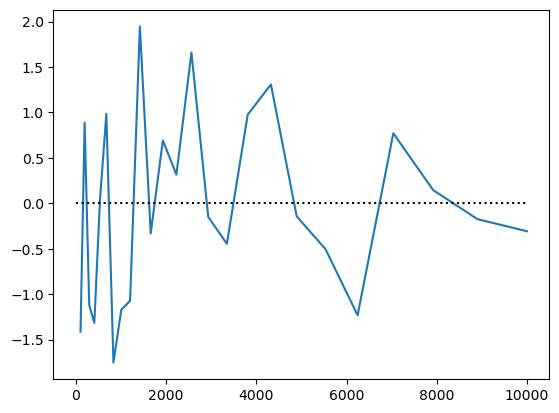

In [95]:
plt.plot(kernels[(kernels.type=='tours')&(kernels.subj==2)].filter_freq,
         kernels[(kernels.type=='tours')&(kernels.subj==2)].norm_gain)
plt.plot([0,10000],[0,0],'k:')

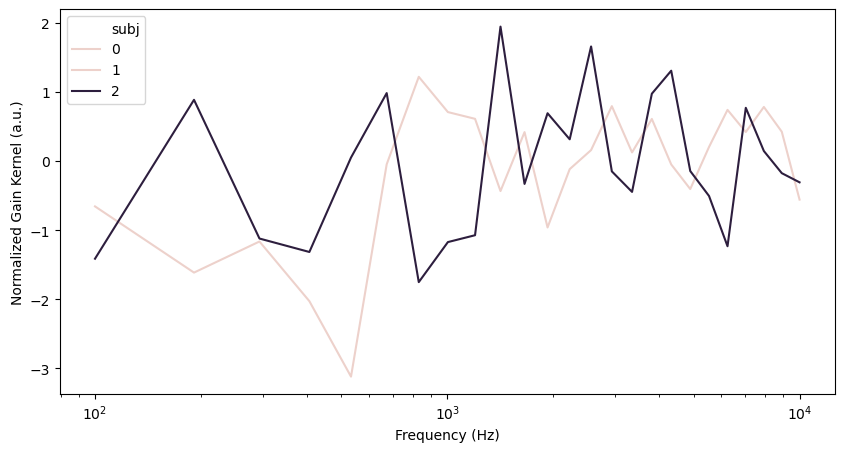

In [58]:
fig,ax = plt.subplots(figsize=(10,5))

plt.plot(kernels[(kernels.type=='tours')&(kernels.subj==1)].filter_freq,
         kernels[(kernels.type=='tours')&(kernels.subj==1)].norm_gain)


# display kernels (patients and controls)
sns.lineplot(x="filter_freq",
             y="norm_gain",
             hue ='subj',
             data=kernels[((kernels.session==1) 
                           & (kernels.subj.isin([1,2]))
                           & (kernels.type=='tours'))],
             ci=95, 
             ax=ax)
_=ax.set_xlabel("Frequency (Hz)")
_=ax.legend(loc='upper left')
_=ax.set_ylabel("Normalized Gain Kernel (a.u.)")
#_=ax.plot([0,crop_x],[0,0],color='k',linestyle = ':')
#_=ax.set_title(title)
_=plt.xscale('log')
#_=ax.set_xlim([100,crop_x])

### Spectral envelopes

We use the vmo smile transformation to extract spectral envelopes

In [32]:
def spectral_env(wave_in, sr): 
    # extract mean spectral envelope from wave_file using the vmo smile transform
    syn, tts, f0s, envs_ori, envs_new  = vmo.smile(wave_in,sr, alpha=1.)
    env = np.mean(envs_ori,0)
    f = np.linspace(0,sr/2,len(env))
    return f,env 

In [115]:
from IPython.display import Markdown, display, Audio
input_file = 'M_n_cut.wav'
wave_in,sr =  vmo.readwav(input_file)

print("son de base")
Audio(data=wave_in, rate=sr)

print("souriant enfant")
kernel_enfant = kernels[(kernels.type=='tours')&(kernels.subj==2)]
wave_out, bpf_out = apply_kernel(wave_in, sr, kernel_enfant.filter_freq, kernel_enfant.norm_gain, 0.8)
Audio(data=wave_out, rate=sr)

print("souriant marie")
kernel_enfant = kernels[(kernels.type=='tours')&(kernels.subj==1)]
wave_out, bpf_out = apply_kernel(wave_in, sr, kernel_enfant.filter_freq, kernel_enfant.norm_gain, 0.8)
Audio(data=wave_out, rate=sr)

print("souriant controles")
kernel_enfant = kernels[(kernels.type=='controls')].groupby("filter_freq").norm_gain.mean().reset_index()
wave_out, bpf_out = apply_kernel(wave_in, sr, kernel_enfant.filter_freq, kernel_enfant.norm_gain, 0.8)
Audio(data=wave_out, rate=sr)

son de base


souriant enfant


souriant marie


souriant controles


581.396484375
1162.79296875
2670.1171875
3552.978515625


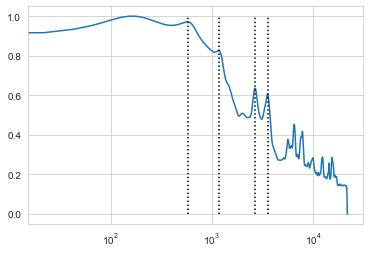

In [33]:
# extract base envelope
input_file = 'M_n_cut.wav'
wave_in,sr =  vmo.readwav(input_file)
base_f, base_env = spectral_env(wave_in,sr)
# normalize amplitude & log
base_env = np.log(base_env)
base_env = (base_env - np.min(base_env))
base_env = (base_env / np.max(base_env))
# extract formants
from scipy.signal import argrelextrema
peaks = base_f[argrelextrema(base_env, np.greater)]
base_formants = peaks[(500<peaks) & (peaks<5000)]
base_formants = base_formants[[0,1,3,4]]

_=plt.plot(base_f, base_env)
plt.xscale('log')
for formant in base_formants:
    _=plt.plot([formant,formant],[0, 1], 'k:')
    print(formant)

In [34]:
def apply_kernel(wave_in, sr, filter_freq, filter_gain, gain):
        
    # create bpf
    num_channel = len(filter_freq)
    bpf = np.zeros((1,2+2*num_channel))
    bpf_val = []
    for f,g in zip(filter_freq,filter_gain): 
        bpf_val += f, np.exp(gain*g)
    #bpf_val += sr/2, 1
    bpf_val = np.array([0, 25] + bpf_val)
    bpf[0,:] = bpf_val
    
    # process with cleese
    config_file = "random_eq_profile.py"
    wav_out,bpf_out = cleese.process(soundData=wave_in, configFile=config_file, sr=sr, BPF=bpf)
    
    return wav_out, bpf_out

In [35]:
def visualize_kernel(wave_in, sr, filter_freq, filter_gain, ax1, gain_range):
    
    # apply kernel with several gains, and store in dataframe
    #gain_range = np.arange(2,-0.5,-0.1)
    freqs = []
    amps = []
    gains = []
    for gain in gain_range:
        wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                         sr=sr,
                                         filter_freq=filter_freq, 
                                         filter_gain=filter_gain,
                                         gain=gain)
    
        f_out,env_out = spectral_env(wave_out,sr)
        freqs+=list(f_out)
        amps+=[np.log(g) for g in list(env_out)]
        gains+=len(f_out)*[gain]
        
    data = pd.DataFrame.from_dict({'f':freqs, 'amp':amps, 'gain':gains})
    
    # plot
    sns.lineplot(data=data, 
            x='f',
            y='amp',
            hue='Gain ' + data['gain'].astype(str), 
            palette="RdBu", 
            ax=ax1)
    _=plt.xscale('log')
    #_=plt.xlim([400, 2000])
    #_=plt.ylim([-10,-2])
    _=plt.legend('',frameon=False)

    # plot original env
    f_in, env_in = spectral_env(wave_in,sr)
    _=plt.plot(f_in,[np.log(g) for g in list(env_in)], 'k')

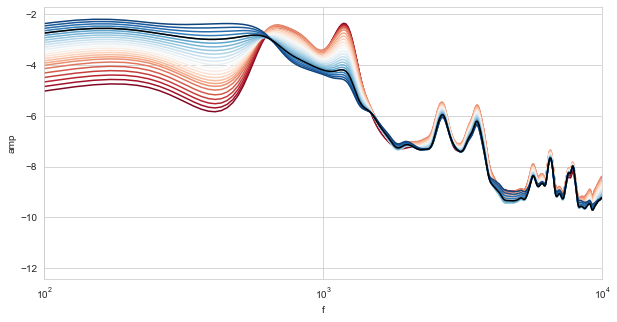

In [36]:
# figure JASA
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
control_kernels = kernels[kernels['type']=='controls'].groupby('filter_freq')['norm_gain'].mean().reset_index()
visualize_kernel(wave_in, sr, list(control_kernels.filter_freq), list(control_kernels.norm_gain), ax, np.arange(2,-0.5,-0.1))
_=plt.xlim([100, 10000])

### Comparaison des kernels des patients vs controls a la session 1

In [102]:
def display_kernel_enveloppe(kernels_df, subjects, session, title, ax1):
    
    crop_x = 10000 # Hz
    enveloppe_gain = 5
    
    # display kernels (patients and controls)
    sns.lineplot(x="filter_freq",
             y="norm_gain",
             hue ='subj',
             data=kernels[((kernels.session==session)
                           & (kernels.subj.isin(subjects))
                           & (kernels.type=='tours'))],
             ci=95, ax=ax1)
    _=ax1.set_xlabel("Frequency (Hz)")
    _=ax1.legend(loc='upper left')
    _=ax1.set_ylabel("Normalized Gain Kernel (a.u.)")
    _=ax1.plot([0,crop_x],[0,0],color='k',linestyle = ':')
    _=ax1.set_title(title)
    _=plt.xscale('log')
    _=ax1.set_xlim([100,crop_x])

    # display base enveloppe
    _=plt.plot(base_f, enveloppe_gain**base_env,'k')
    
    # display base formants 
    for index, formant in enumerate(base_formants):
        _=plt.plot([formant,formant],[0, enveloppe_gain-1], 'k:')
        _=plt.text(formant, enveloppe_gain-0.9, 'F'+str(index+1), horizontalalignment = 'center')

    # display enveloppe filtered by patient kernel
    patient_kernels = kernels[(kernels.type=='tours')
                              & (kernels.session==session)
                              & (kernels.subj.isin(subjects))].groupby('filter_freq')['norm_gain'].mean().reset_index()
    filter_freq = list(patient_kernels.filter_freq)
    filter_gain = list(patient_kernels.norm_gain)
        
    wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                 sr=sr,
                                 filter_freq=filter_freq,
                                 filter_gain=filter_gain, 
                                 gain=1.5)
    f_out,env_out = spectral_env(wave_out,sr)
    env_out = np.log(env_out)
    env_out = (env_out - np.min(env_out))
    env_out = (env_out / np.max(env_out))
    _=plt.plot(f_out, enveloppe_gain**env_out,color='orange')

    # display enveloppe filtered by control kernel
    control_kernels = kernels[kernels['type']=='controls'].groupby('filter_freq')['norm_gain'].mean().reset_index()
    filter_freq = list(control_kernels.filter_freq)
    filter_gain = list(control_kernels.norm_gain)
    wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                 sr=sr,
                                 filter_freq=filter_freq,
                                 filter_gain=filter_gain, 
                                 gain=1.5)
    f_out,env_out = spectral_env(wave_out,sr)
    env_out = np.log(env_out)
    env_out = (env_out - np.min(env_out))
    env_out = (env_out / np.max(env_out))
    _=plt.plot(f_out, enveloppe_gain**env_out,color='b')


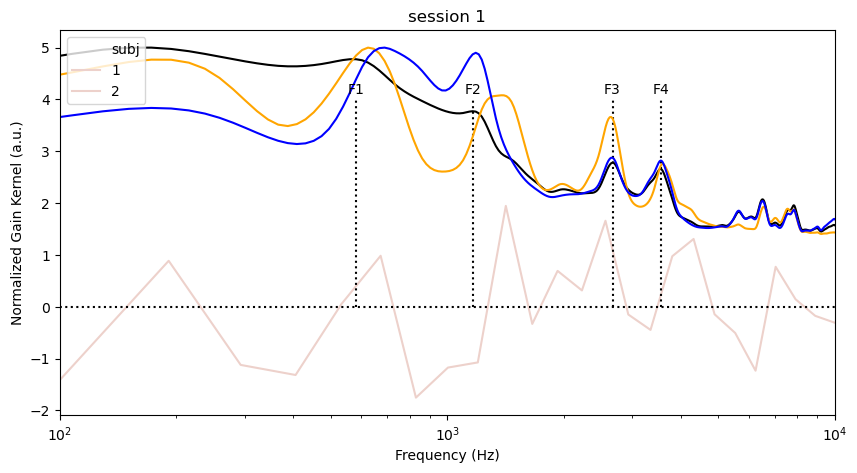

In [103]:
fig,ax = plt.subplots(figsize=(10,5))
_=plt.style.use('default')
patients = [2]# np.arange(1,8)
session = 1
display_kernel_enveloppe(kernels,patients, session, 'session %d'%(session),ax)
    
#fig.savefig('all_patients_1.svg', format='svg')
#fig.savefig('patient %d.svg'%patient, format='svg')

In [39]:
# statistiques: independent t-test between patient and control norm_gain at each filter frequency

import scipy.stats as st

freqs = list(kernels.filter_freq.unique())
alpha=0.05

for freq in freqs: 
    
    patient_kernels = list(kernels[(kernels.type=='patients')
                            & (kernels.filter_freq==freq)
                                  & (kernels.session == 1)].norm_gain)
    control_kernels = list(kernels[(kernels.type=='controls')
                            & (kernels.filter_freq==freq)].norm_gain)
    
    t,p = st.ttest_ind(patient_kernels,control_kernels)
    print("%d Hz: t = %6.3f p = %6.4f" %(freq,t,p), end='')
    if (p<alpha):
        print(' (*) ')
    else:
        print()

100 Hz: t = -0.998 p = 0.3343
191 Hz: t = -0.827 p = 0.4215
293 Hz: t =  0.175 p = 0.8634
406 Hz: t =  3.014 p = 0.0087 (*) 
533 Hz: t =  3.794 p = 0.0018 (*) 
673 Hz: t = -0.318 p = 0.7546
830 Hz: t =  0.335 p = 0.7426
1004 Hz: t =  2.455 p = 0.0268 (*) 
1199 Hz: t = -0.569 p = 0.5779
1416 Hz: t =  0.561 p = 0.5829
1657 Hz: t = -0.391 p = 0.7014
1926 Hz: t =  0.048 p = 0.9623
2226 Hz: t =  0.220 p = 0.8288
2560 Hz: t = -1.267 p = 0.2245
2932 Hz: t =  0.686 p = 0.5029
3346 Hz: t = -3.308 p = 0.0048 (*) 
3808 Hz: t = -2.722 p = 0.0157 (*) 
4322 Hz: t =  2.341 p = 0.0335 (*) 
4895 Hz: t = -1.867 p = 0.0815
5534 Hz: t = -0.787 p = 0.4435
6245 Hz: t = -0.823 p = 0.4236
7037 Hz: t = -0.609 p = 0.5518
7920 Hz: t = -1.485 p = 0.1581
8904 Hz: t = -1.825 p = 0.0879
10000 Hz: t = -2.503 p = 0.0244 (*) 


### Significativité individuelle des kernels patients

In [40]:
# trial per trial data
positives = data.loc[data['response'] == 1].reset_index()
negatives = data.loc[data['response'] == 0].reset_index()[['subj','type','session','trial','filter_freq','filter_gain']]
trial_data = pd.merge(positives, negatives, 
                      on=['subj','type','session','trial','filter_freq'],
                     suffixes=('','_y'))
trial_data['kernel_gain'] = trial_data['filter_gain'] - trial_data['filter_gain_y']

# normalisation
# request "for_norm", computed above
trial_data = pd.merge(trial_data, for_norm, on=['subj','type','session'])
trial_data['norm_gain'] = trial_data['kernel_gain']/np.sqrt(trial_data['square_gain'])

trial_data.drop(columns=['filter_gain','response','filter_gain_y','square_gain'], inplace=True)

In [224]:
import scipy.stats as st

# t-tests à 0
def ttest(x):
    return "t = %6.3f p = %6.4f" %st.ttest_1samp(list(x), 0)

kernel_stats = trial_data.groupby(['type','session','subj','filter_freq']).agg({'norm_gain':['mean',ttest],
                                                                                'trial':'count'}).reset_index()
# make column names on one level
kernel_stats.columns = ['_'.join(tup).rstrip('_') for tup in kernel_stats.columns.values]

# display all
datasets = [{'type':'patients','session':1},
            {'type':'patients','session':2},
            {'type':'patients','session':3},
            {'type':'controls','session':1}]
alpha = .05
for dataset_index, dataset in enumerate(datasets): 
    
    print("\n%s: SESSION%d"%(dataset['type'].upper(),dataset['session']))
    
    participants = kernel_stats[(kernel_stats.session==dataset['session'])
                              &(kernel_stats.type==dataset['type'])].subj.unique()
    n_participants=len(participants)
    
    for participant in participants: 
        
        print("\n%s %d"%(dataset['type'].upper()[:-1],participant))
        
        for index, row in kernel_stats[(kernel_stats.session==dataset['session'])
                              &(kernel_stats.subj==participant)         
                              &(kernel_stats.type==dataset['type'])].iterrows(): 
            print('%sHz: %s'%(row['filter_freq'],row['norm_gain_ttest']), end ='')
            if float(row['norm_gain_ttest'].split("=")[-1])<alpha: 
                print(' (*) ')
            else: 
                print()
            


PATIENTS: SESSION1

PATIENT 1
100Hz: t = -5.195 p = 0.0000 (*) 
191Hz: t = -2.180 p = 0.0300 (*) 
293Hz: t = -1.308 p = 0.1919
406Hz: t =  1.983 p = 0.0482 (*) 
533Hz: t =  1.218 p = 0.2240
673Hz: t =  1.496 p = 0.1356
830Hz: t =  1.084 p = 0.2792
1004Hz: t =  1.066 p = 0.2872
1199Hz: t =  2.260 p = 0.0246 (*) 
1416Hz: t = -1.250 p = 0.2122
1657Hz: t = -0.032 p = 0.9744
1926Hz: t = -0.627 p = 0.5312
2226Hz: t =  1.376 p = 0.1698
2560Hz: t =  0.428 p = 0.6686
2932Hz: t =  0.030 p = 0.9760
3346Hz: t = -0.806 p = 0.4211
3808Hz: t =  0.983 p = 0.3264
4322Hz: t =  0.102 p = 0.9192
4895Hz: t = -1.393 p = 0.1646
5534Hz: t =  0.492 p = 0.6232
6245Hz: t =  1.456 p = 0.1464
7037Hz: t = -0.685 p = 0.4939
7920Hz: t =  0.234 p = 0.8152
8904Hz: t = -1.833 p = 0.0677
10000Hz: t = -1.201 p = 0.2305

PATIENT 2
100Hz: t =  0.129 p = 0.8976
191Hz: t = -1.612 p = 0.1080
293Hz: t = -2.886 p = 0.0042 (*) 
406Hz: t = -1.962 p = 0.0507
533Hz: t = -0.319 p = 0.7497
673Hz: t =  0.116 p = 0.9080
830Hz: t =  1.8

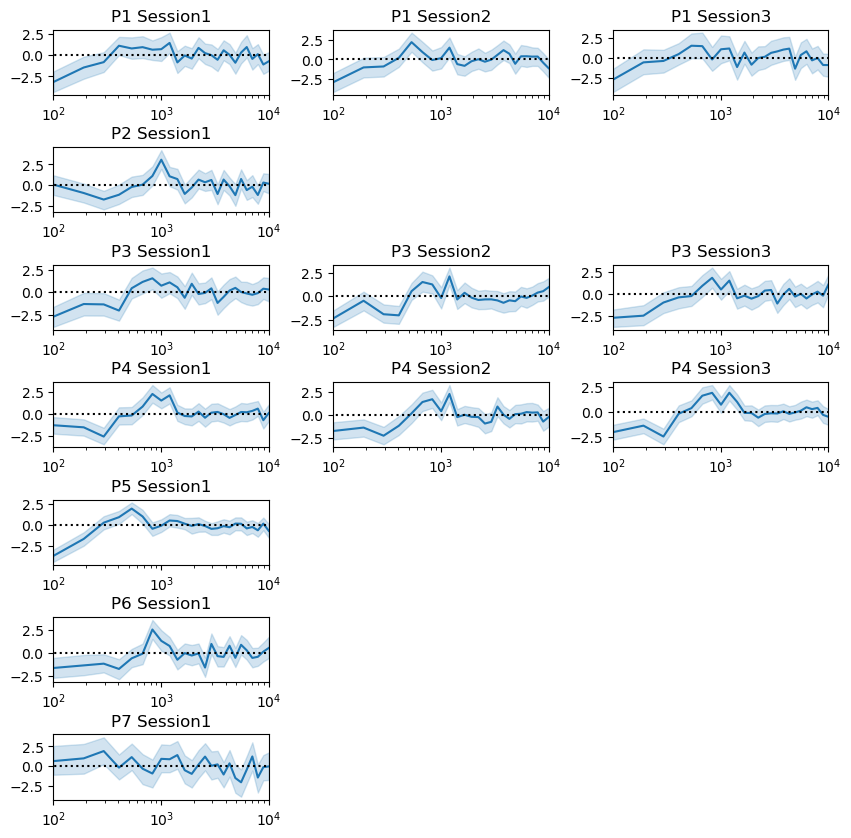

In [225]:
# comparaison entre session 1 et session 2, au niveau individuel
fig = plt.figure(figsize=(10,10))
_=fig.subplots_adjust(wspace=0.3,hspace=0.8)

# participants who have a 2nd session
participants = trial_data[trial_data.type=='patients'].subj.unique()
n_participants=len(participants)
sessions = [1,2,3]
 
for participant_index, participant in enumerate(participants): 
 
    for session in sessions: 
        
        if session in list(trial_data[(trial_data.subj==participant)
                                &(trial_data.type=='patients')].session.unique()):
            
            ax1 = fig.add_subplot(n_participants,3, participant_index*3+session)
            _=sns.lineplot(x="filter_freq",
                         y="norm_gain",
                         data=trial_data[(trial_data.type=='patients')
                                         &(trial_data.session == session)
                                         &(trial_data.subj == participant)],
                         ci=95,n_boot=1000,
                         ax=ax1)
            _=plt.xlabel("")
            _=plt.ylabel("")
            _=plt.xscale('log')
            _=plt.yticks()
            _=plt.xlim([100,10000])
            _=plt.plot([0,10000],[0,0],color='k',linestyle = ':')
            _=plt.title('P%d Session%d'%(participant, session))
    


### Comparaison des kernels entre sessions

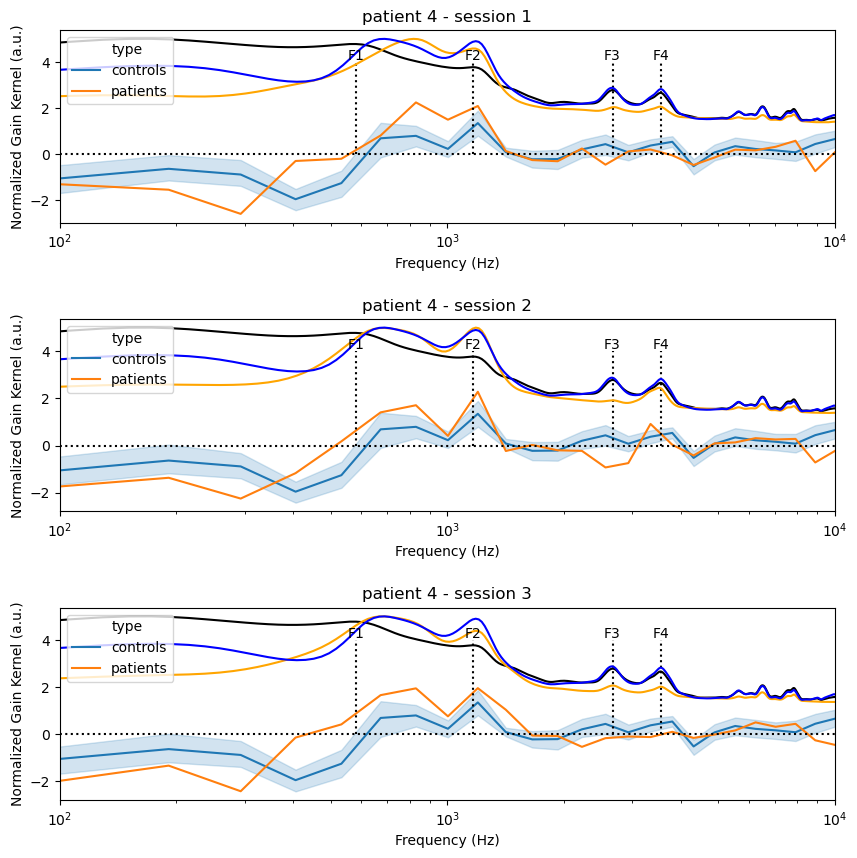

In [246]:


fig = plt.figure(figsize=(10,10))
_=plt.style.use('default')
fig.subplots_adjust(hspace=0.5)
sessions = [1,2,3]
#patients = [1,3,4]
patient = 4
for session in sessions: 
    ax = fig.add_subplot(3,1,session)
    display_kernel_enveloppe(kernels,[patient], session, 'patient %d - session %d'%(patient,session),ax)
 #   display_kernel_enveloppe(kernels,patients, session, 'all patients - session %d'%(session),ax)
    
#fig.savefig('all_patients.svg', format='svg')
fig.savefig('patient %d.svg'%patient, format='svg')

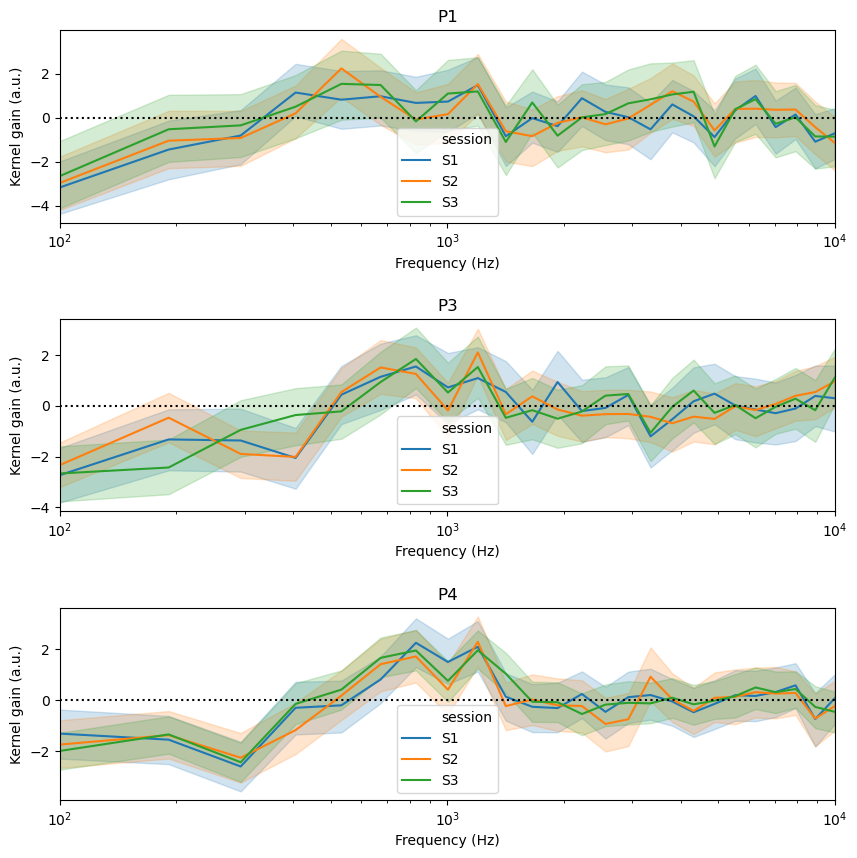

In [229]:
# comparaison entre session 1 et session 2, au niveau individuel
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.5)    
# participants who have a 2nd session
participants = trial_data[(trial_data.session==2)
                              &(trial_data.type=='patients')].subj.unique()
n_participants=len(participants)
 
for participant_index, participant in enumerate(participants): 
    
    ax1 = fig.add_subplot(n_participants,1, participant_index+1)
    _=sns.lineplot(x="filter_freq",
                 y="norm_gain",
                 hue='S' + trial_data['session'].astype(str), #cast hue as categorical
                 data=trial_data[(trial_data.type=='patients')
                                  &(trial_data.subj == participant)],
                 ci=95,n_boot=1000,
                 ax=ax1)
    _=plt.xlabel("Frequency (Hz)")
    _=plt.ylabel("Kernel gain (a.u.)")
    _=plt.xscale('log')
    #plt.ylim([-3,3])
    _=plt.xlim([100,10000])
    _=plt.plot([0,10000],[0,0],color='k',linestyle = ':')
    _=plt.title('P%d'%participant)
    


### Accuracy from controls

Calcule la distance de chaque kernel de patient à celui du kernel moyen des controles.\
Si la distance est grande (ex. commere_3, jeulin_6), la représentation mentale du patient est très altérée.\
Si la distance est faible (ex. bardet_7, commere_10), la représentation mentale du patient est normale.\
On imagine qu'on peut tester des corrélations entre cette distance et les paramètres cliniques du patient

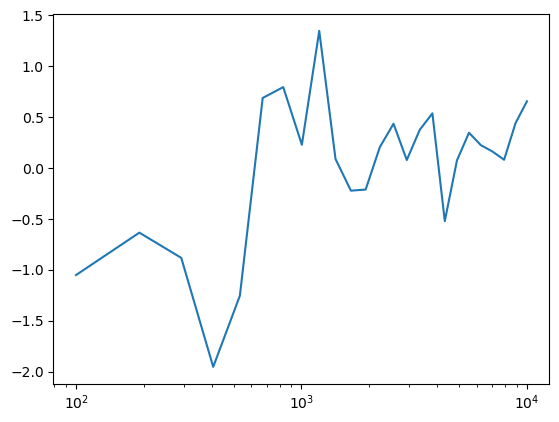

In [147]:
control_kernels = kernels[kernels['type']=='controls'].groupby('filter_freq')['norm_gain'].mean().reset_index()
plt.plot(list(control_kernels.filter_freq),list(control_kernels.norm_gain))
plt.xscale('log')

type      session
controls  1          0.611980
patients  1          0.569071
          2          0.616062
          3          0.620519
Name: hit, dtype: float64

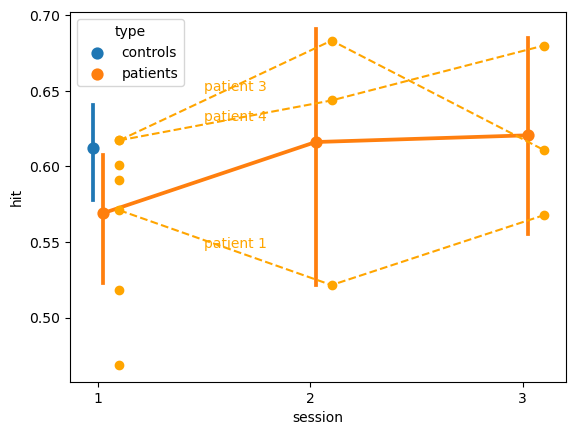

In [251]:
def dot_control(x):
    return np.dot(list(x), list(control_kernels.norm_gain))

# trial per trial data
positives = data.loc[data['response'] == 1].reset_index()
negatives = data.loc[data['response'] == 0].reset_index()[['subj','type','session','trial','filter_freq','filter_gain']]
trial_data = pd.merge(positives, negatives, 
                      on=['subj','type','session','trial','filter_freq'],
                     suffixes=('','_y'))
# dot product of each positive and negative trial with control kernel
trial_data = trial_data.groupby(['subj','type','session','trial']).agg({'filter_gain':dot_control,
                                                                                       'filter_gain_y':dot_control}).reset_index()
trial_data['hit'] = trial_data['filter_gain'] > trial_data['filter_gain_y'] 

sns.pointplot(x="session",
              y="hit",
              hue='type',
              data=trial_data,
              units="subj",
              dodge=True,
              ci=95,n_boot=1000)

for patient in np.arange(1,8):
    x=list(trial_data[(trial_data.subj==patient) 
                    & (trial_data.type=='patients')].session.unique()-0.9)
    y=list(trial_data[(trial_data.subj==patient) 
                    & (trial_data.type=='patients')].groupby('session').hit.mean())
    _=plt.plot(x,y,'--o', color='orange')
    if patient in [1,3,4]:
        _=plt.text(0.5, np.mean(y[0:2]), 'patient %d'%patient, color='orange')

trial_data.groupby(['type','session']).hit.mean()

#sns.lineplot(x=trial_data[trial_data.type=='patients'].session-1,
#             y="hit",
#             hue='S'+trial_data[trial_data.type=='patients']['subj'].astype(str),
#             hue_order=['S1','S3','S4'],
#             data=trial_data[trial_data.type=='patients'],
#             ci=None)

fig.savefig('accuracy.svg', format='svg')

In [253]:
trial_data[trial_data.subj.isin([1,3,4])].groupby(['type','session']).hit.mean()

type      session
controls  1          0.640044
patients  1          0.601760
          2          0.616062
          3          0.620519
Name: hit, dtype: float64

In [252]:
patient_trials = list(trial_data[(trial_data.type=='patients')
                            & (trial_data.session==1)].hit)
control_trials = list(trial_data[(trial_data.type=='controls')
                            & (trial_data.session==1)].hit)
    
t,p = st.ttest_ind(patient_trials,control_trials)
print("t = %6.3f p = %6.4f" %(freq,t,p), end='')
if (p<alpha):
    print(' (*) ')
else:
    print()

10000 Hz: t = -3.471 p = 0.0005 (*) 
